In [ ]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import sqlalchemy
from sqlalchemy import Column, Integer, String, Float


from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect
from sqlalchemy import func
from sqlalchemy import desc

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

In [ ]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [ ]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [ ]:
Base.classes.keys()

In [ ]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [ ]:
Session = Session(engine)

In [ ]:
Inspect = inspect(engine)

### Basic Data engineering task

In [ ]:
Inspect.get_table_names()

In [ ]:
columns_measurement = Inspect.get_columns('measurement')
for cols in columns_measurement:
    print(cols["name"], cols["type"])

In [ ]:
columns_station = Inspect.get_columns('station')
for cols in columns_station:
    print(cols["name"], cols["type"])

In [ ]:
Result = Session.execute("SELECT count(*) FROM Measurement").fetchall()
print(Result)

In [ ]:
Result = Session.execute("SELECT count(*) FROM Station").fetchall()
print(Result)

In [ ]:
Result = Session.execute("SELECT count(*) FROM Measurement WHERE station is Null").fetchall()
print(Result)

In [14]:
Result = Session.execute("SELECT count(*) FROM Measurement WHERE date is Null").fetchall()
print(Result)

[(0,)]


In [15]:
Result = Session.execute("SELECT count(*) FROM Measurement WHERE prcp is Null").fetchall()
print(Result)

[(0,)]


In [16]:
Result = Session.execute("SELECT count(*) FROM Measurement WHERE tobs is Null").fetchall()
print(Result)

[(0,)]


In [17]:
Result = Session.execute("SELECT count(*) FROM Station WHERE station is Null").fetchall()
print(Result)

[(0,)]


In [18]:
Result = Session.execute("SELECT count(*) FROM Station WHERE name is Null").fetchall()
print(Result)

[(0,)]


In [19]:
Result = Session.execute("SELECT count(*) FROM Station WHERE latitude is Null").fetchall()
print(Result)

[(0,)]


In [20]:
Result = Session.execute("SELECT count(*) FROM Station WHERE longitude is Null").fetchall()
print(Result)

[(0,)]


In [21]:
Result = Session.execute("SELECT count(*) FROM Station WHERE elevation is Null").fetchall()
print(Result)

[(0,)]


In [23]:
Session.execute("Update Measurement SET prcp=0.0 WHERE prcp is NULL")

In [24]:
Session.commit()

In [25]:
Result = Session.execute("SELECT count(*) FROM Measurement WHERE prcp is Null").fetchall()
print(Result)

[(0,)]


## Exploratory Climate Analysis

In [26]:
Latest_date = Session.execute("SELECT MAX(date) FROM Measurement").fetchall()

Latest_date = Session.query(func.max(Measurement.date)).all()

End_Date = Latest_date[0][0]
print(End_Date)

2017-08-23


In [27]:
Struct = dt.date.today()
End_Date_dateformat = Struct.replace(year=int(End_Date[:4]),month=int(End_Date[5:7]),day=int(End_Date[8:]))
Last_date_year = End_Date_dateformat - dt.timedelta(days=365)    
Start_Date = Last_date_year.strftime("%Y-%m-%d")
print(Start_Date)

2016-08-23


In [28]:
print("Date range is starting from {} and ending at {}".format(Start_Date,End_Date))

Date range is starting from 2016-08-23 and ending at 2017-08-23


In [29]:
PRCP_data = Session.query(Measurement.date,Measurement.prcp)\
                          .filter(Measurement.date <= End_Date)\
                          .filter(Measurement.date >= Start_Date)\
                          .order_by(Measurement.date.desc()).all()

In [30]:
PRCP_data_DF = pd.DataFrame(PRCP_data).rename(columns={"date":"Date","prcp":"Precipitation Score"})
PRCP_data_DF.set_index("Date",inplace=True)
PRCP_data_DF.head()

,Precipitation Score
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


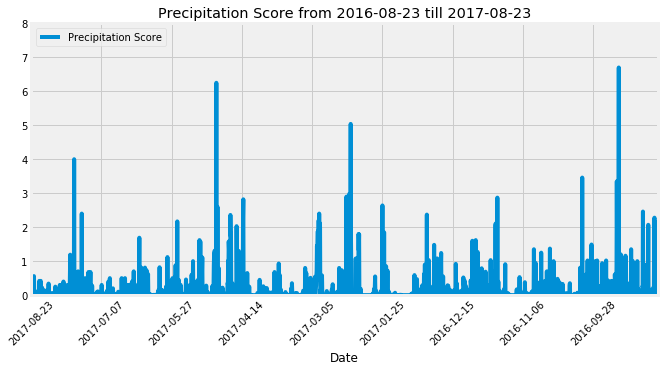

In [31]:
PRCP_data_DF.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation Score from {Start_Date} till {End_Date}',\
                  label="Precipitation",rot=45)
plt.legend(loc="upper left")
plt.savefig("Images/1_Precipitation_Analysis.jpg")
plt.show()

In [32]:
PRCP_data_DF.describe()

,Precipitation Score
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [33]:
Total_stations = Session.query(Station).count()
print('Total number of stations is: {}'.format(Total_stations))

Total number of stations is: 9


In [34]:
Most_Active_stations = Session.query(Measurement.station,func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(desc(func.count(Measurement.station))).all()

In [35]:
Most_Active_stations = Session.query(Measurement.station,func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(desc(func.count(Measurement.station))).all()

In [36]:
print("Rank\tStation ID\tObservations")
i = 1
for active_stations in Most_Active_stations:
    print("%d\t%s\t%d" %(i,active_stations[0],active_stations[1]))
    i+=1

Rank	Station ID	Observations
1	USC00519281	2772
2	USC00519397	2724
3	USC00513117	2709
4	USC00519523	2669
5	USC00516128	2612
6	USC00514830	2202
7	USC00511918	1979
8	USC00517948	1372
9	USC00518838	511


In [37]:
Station_Highest_Obs = Session.query(Measurement.station,func.count(Measurement.station))\
                      .group_by(Measurement.station)\
                      .order_by(desc(func.count(Measurement.station))).first()

print("The station with the highest number of observation is "+str(Station_Highest_Obs[0])+" with " +\
      str(Station_Highest_Obs[1]) + " number of observations.")

The station with the highest number of observation is USC00519281 with 2772 number of observations.


In [38]:
Session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                  .filter(Measurement.station == Station_Highest_Obs[0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [39]:
Results = Session.query(Measurement.date,Measurement.station,Measurement.tobs)\
             .filter(Measurement.date >= Start_Date).filter(Measurement.date<=End_Date)\
             .filter(Measurement.station == Station_Highest_Obs[0]).order_by(desc(Measurement.date)).all()

In [40]:
Last12_tobs_DF = pd.DataFrame(Results,columns=["Date","Station ID","Temperature_Recorded"])
Last12_tobs_DF.head()

,Date,Station ID,Temperature_Recorded
0,2017-08-18,USC00519281,79.0
1,2017-08-17,USC00519281,76.0
2,2017-08-16,USC00519281,76.0
3,2017-08-15,USC00519281,77.0
4,2017-08-14,USC00519281,77.0


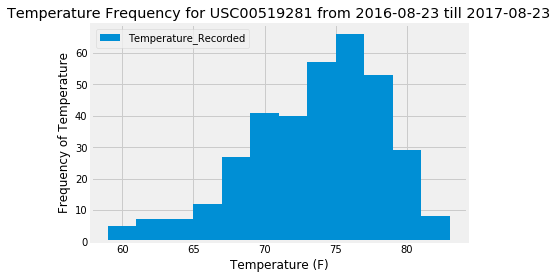

In [41]:
Last12_tobs_DF.plot.hist(by="Temperature_Recorded",bins=12,label="tobs",title=f'Temperature Frequency for {Station_Highest_Obs[0]} from {Start_Date} till {End_Date}')
plt.ylim=(0,80)
plt.ylabel("Frequency of Temperature")
plt.xlabel("Temperature (F)")
plt.legend=()
plt.savefig("Images/2_Temperature_Analysis.jpg")
plt.show()